In this notebook we use all valid variables (all except: "customer_name", "customer_birthdate", "loyalty_card_number") and minmax scaler is used as the scaler

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from minisom import MiniSom
import umap.umap_ as umap

from dendogram_func import plot_dendrogram
from silhouette import plot_silhouette
from dbscan_auxiliary_func import get_kdist_plot
from visualization_umap import visualize_dimensionality_reduction_umap
from radar_plot import create_radar_chart

C:\Users\joaof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importing the datasets and looking ate them

In [2]:
customer_info = pd.read_csv("customer_info.csv", index_col = "customer_id", parse_dates=['customer_birthdate']).drop(columns = "Unnamed: 0")

C:\Users\joaof\AppData\Local\Temp\ipykernel_15256\3321492438.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  customer_info = pd.read_csv("customer_info.csv", index_col = "customer_id", parse_dates=['customer_birthdate']).drop(columns = "Unnamed: 0")


In [3]:
customer_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43631 entries, 39634 to 5120
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   customer_name                            43631 non-null  object        
 1   customer_gender                          43631 non-null  object        
 2   customer_birthdate                       43631 non-null  datetime64[ns]
 3   kids_home                                43107 non-null  float64       
 4   teens_home                               42610 non-null  float64       
 5   number_complaints                        42977 non-null  float64       
 6   distinct_stores_visited                  42322 non-null  float64       
 7   lifetime_spend_groceries                 43631 non-null  float64       
 8   lifetime_spend_electronics               43631 non-null  float64       
 9   typical_hour                             

In [4]:
customer_info.iloc[:,20:22].info()

<class 'pandas.core.frame.DataFrame'>
Index: 43631 entries, 39634 to 5120
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year_first_transaction  43631 non-null  float64
 1   loyalty_card_number     24654 non-null  float64
dtypes: float64(2)
memory usage: 1022.6 KB


In [5]:
customer_info.duplicated().sum()

0

# Some visualizations

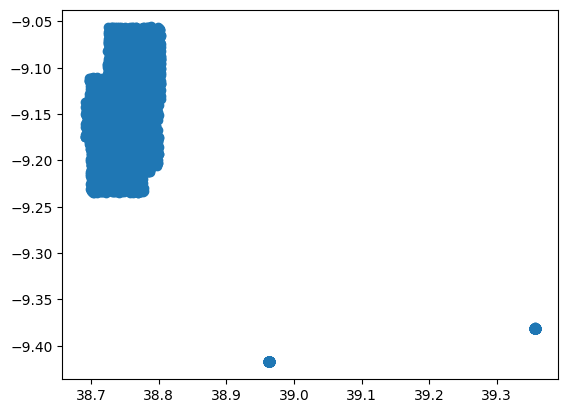

In [6]:
#Plotting longitude and latitude
plt.scatter(x = customer_info["latitude"], y= customer_info["longitude"])
plt.show()

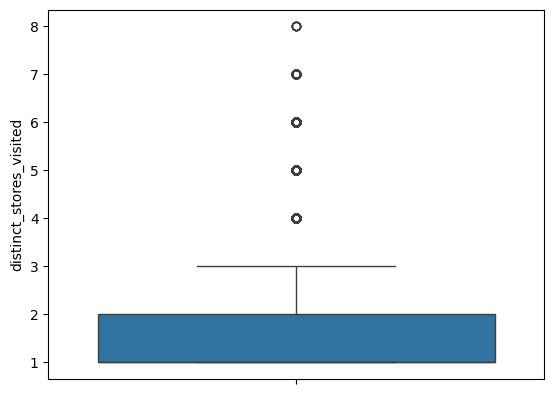

In [7]:
sns.boxplot(data = customer_info, y = "distinct_stores_visited")
plt.show()

In [8]:
customer_info[["lifetime_spend_fish"]]

,lifetime_spend_fish
customer_id,
39634,4056.0
43460,1925.0
23937,2347.0
2431,151.0
10090,172.0
...,...
48487,3779.0
24856,3893.0
21373,142.0


In [9]:
customer_info[["lifetime_spend_fish"]].value_counts()

lifetime_spend_fish
1.0                    3298
0.0                    2624
2.0                     865
3.0                     101
318.0                    42
                       ... 
3079.0                    1
3077.0                    1
3067.0                    1
3065.0                    1
50381.0                   1
Name: count, Length: 4770, dtype: int64

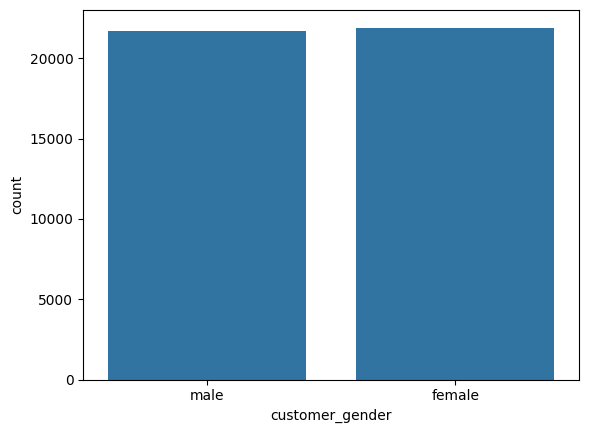

In [10]:
sns.countplot(x='customer_gender', data=customer_info)
plt.show()

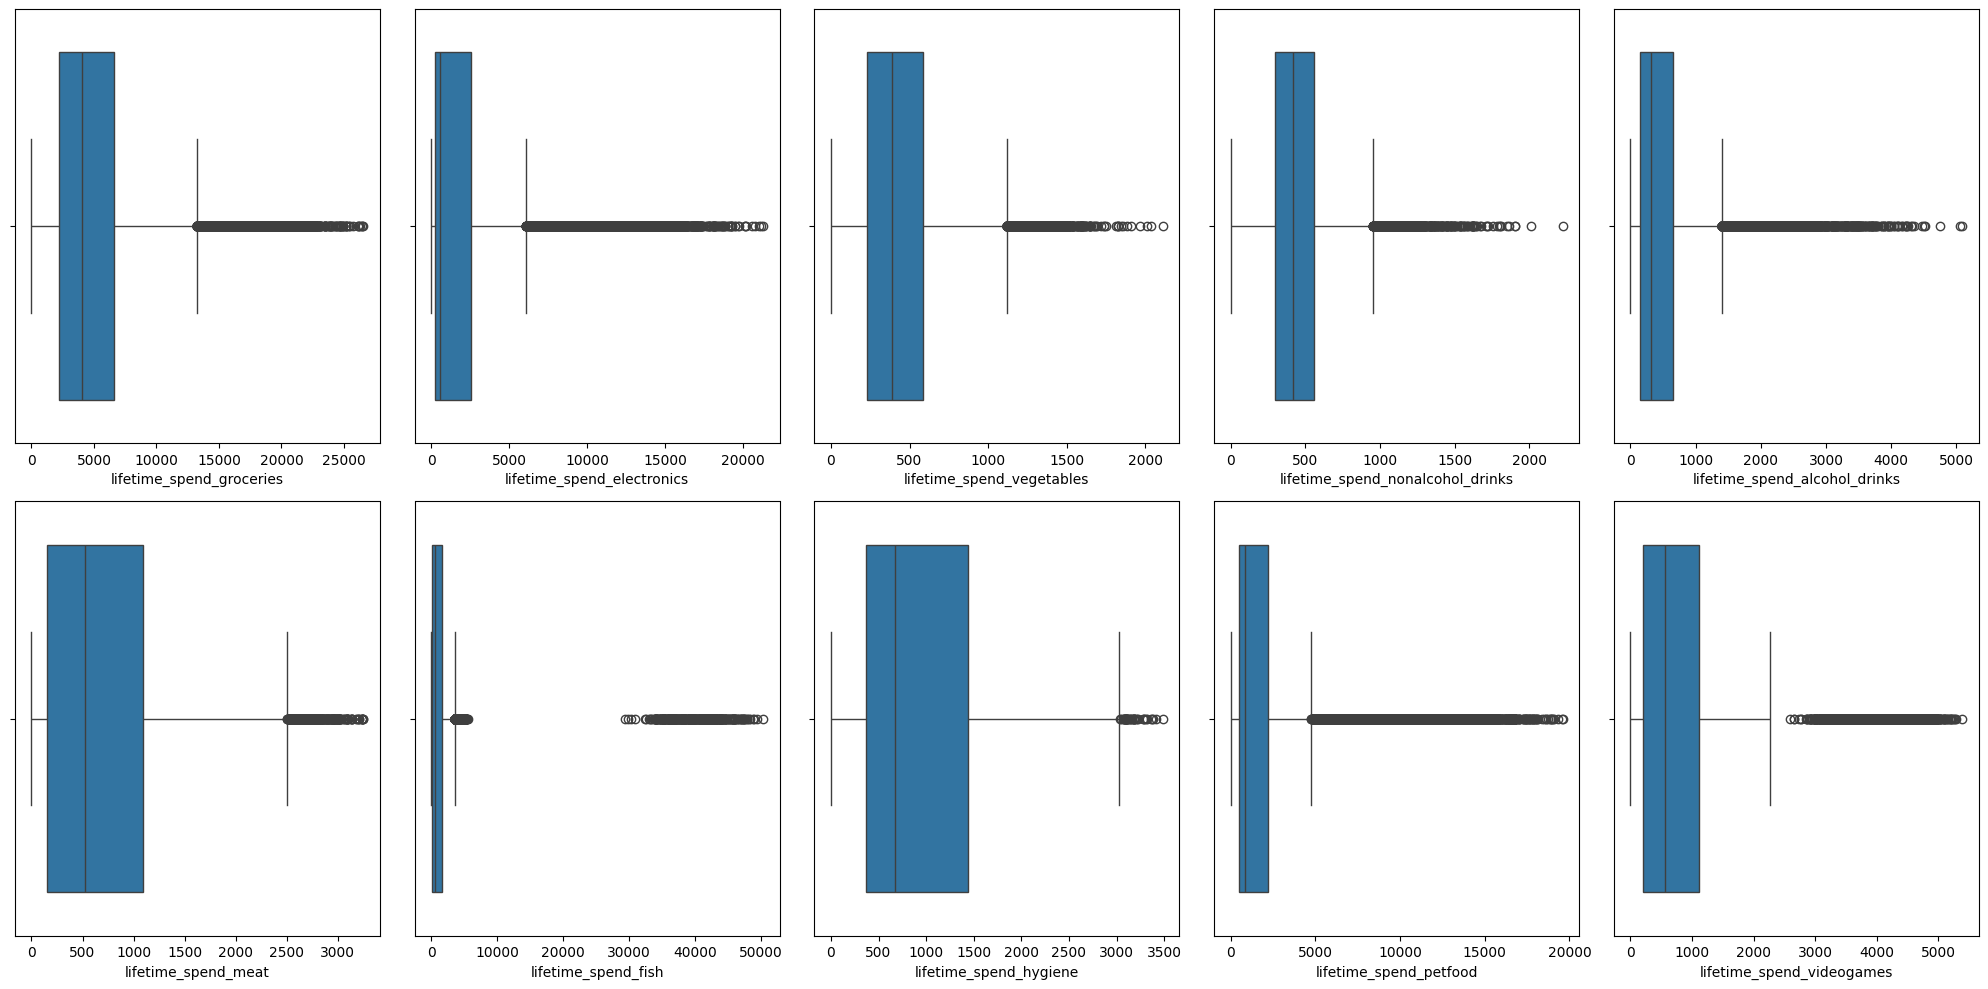

In [11]:
columns = ['lifetime_spend_groceries','lifetime_spend_electronics', 'lifetime_spend_vegetables',
           'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks',
            'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene',
             'lifetime_spend_petfood', 'lifetime_spend_videogames']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
for i, column in enumerate(columns):
        if i// 5 == 0:
                sns.boxplot(x=customer_info[column], ax=axes[0][i])
        else:
                sns.boxplot(x=customer_info[column], ax=axes[1][i-5])
plt.tight_layout()   
plt.show()

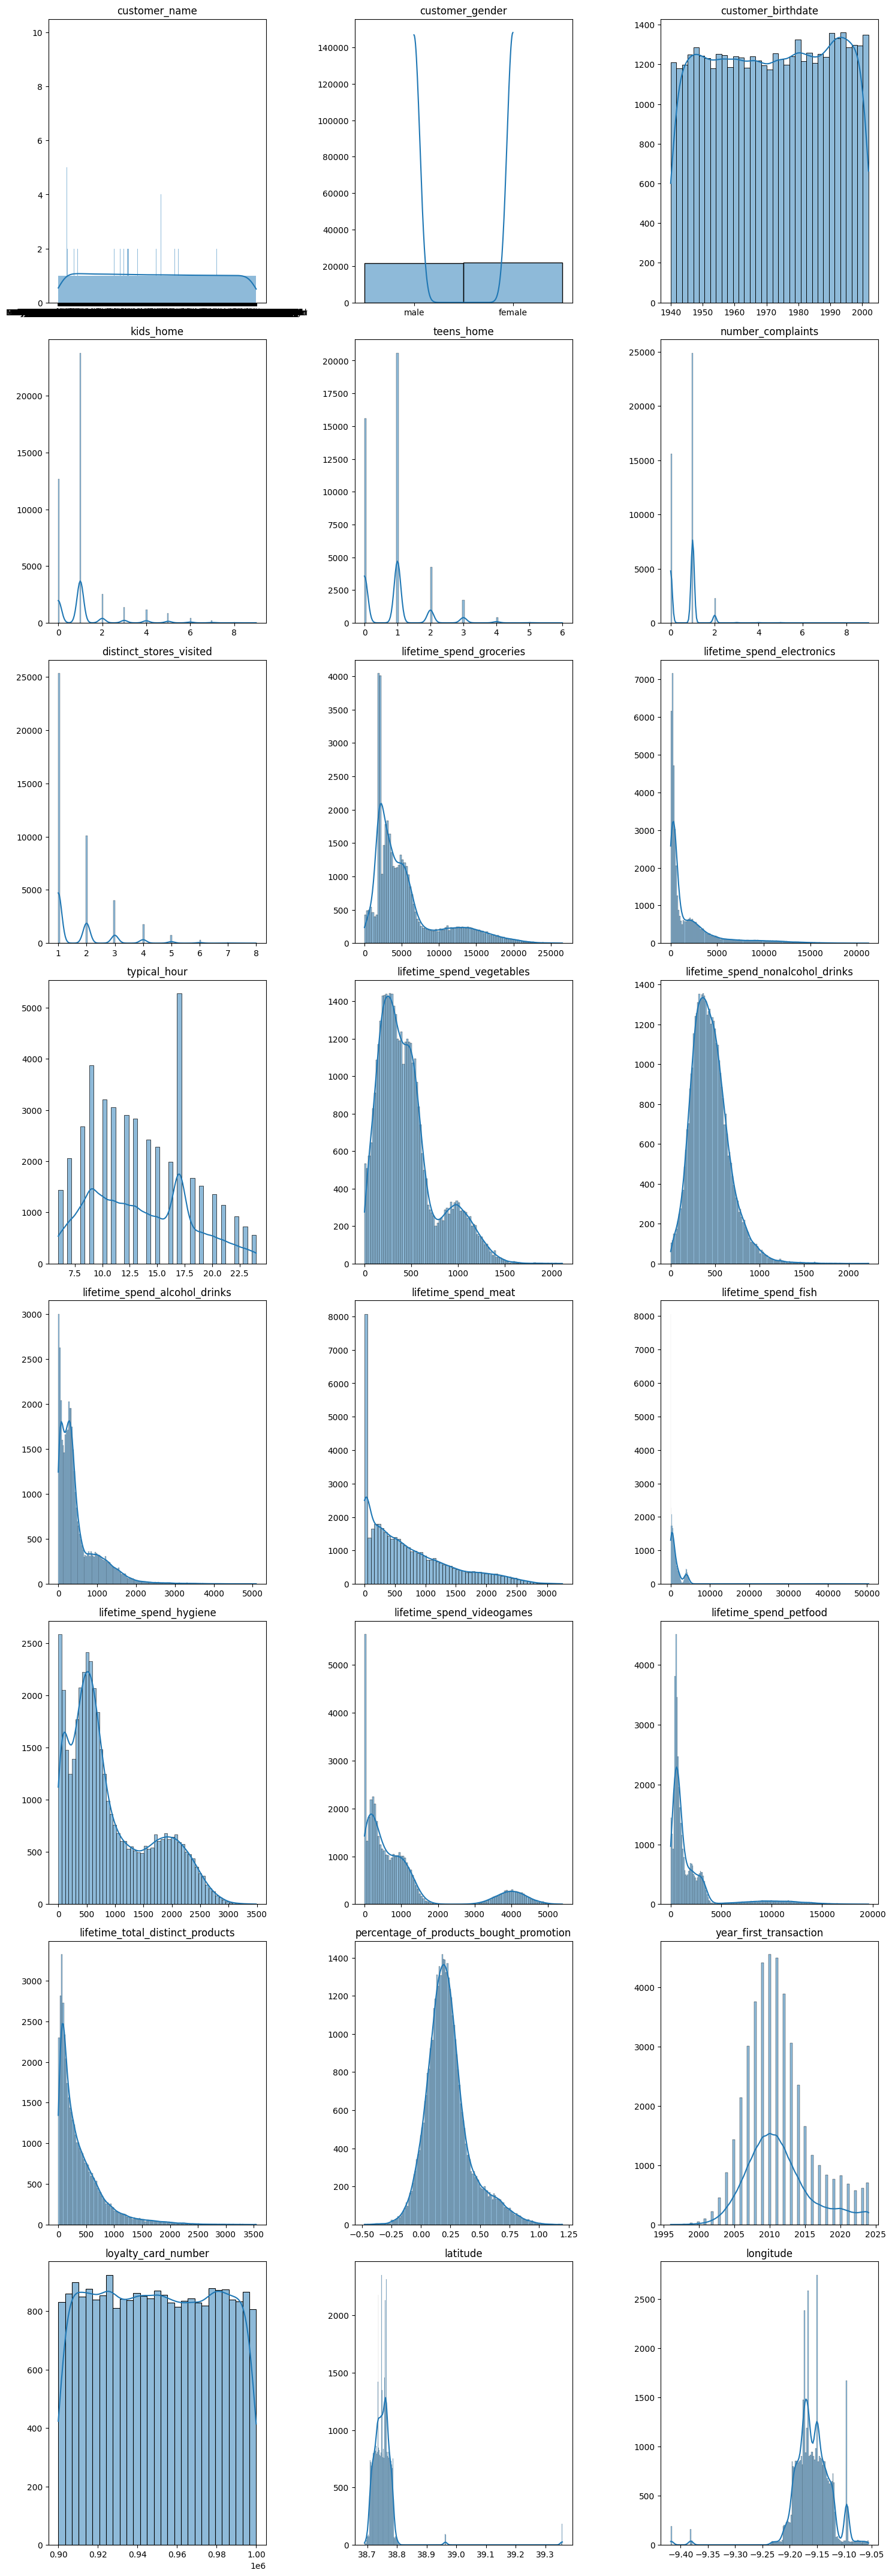

In [20]:
columns_to_visualize = customer_info.columns

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=len(columns_to_visualize)//3 + 1, ncols=3, figsize=(15, len(columns_to_visualize) * 2))

axes = axes.flatten()

# Loop through the columns and create a plot for each
for i, column in enumerate(columns_to_visualize):
    sns.histplot(customer_info[column], ax=axes[i], kde=True)
    axes[i].set_title(column)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()


# Dealing with some outliers (creating a cluster of just fishermen who spend a lot on fish)

In [12]:
customer_info[customer_info["lifetime_spend_fish"] > 15000]

,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
customer_id,,,,,,,,,,,,,,,,,,,,,
48086,Charles`s Fishy,male,1966-09-04 09:18:00,0.0,0.0,1.0,1.0,14998.0,49.0,7.0,...,48432.0,82.0,0.0,0.0,14.0,0.247700,2011.0,NaN,39.356842,-9.380685
31838,Ursula`s Fishy,female,1963-09-20 15:37:00,0.0,0.0,1.0,1.0,13837.0,104.0,9.0,...,45651.0,101.0,0.0,0.0,24.0,-0.038993,2011.0,921411.0,38.963450,-9.417104
41519,Lindsay`s Fishy,female,1956-07-27 18:05:00,0.0,0.0,0.0,1.0,14680.0,167.0,9.0,...,38525.0,148.0,0.0,0.0,33.0,0.399334,2015.0,NaN,38.963252,-9.416521
41076,Carol`s Fishy,female,1942-07-18 08:53:00,0.0,0.0,0.0,1.0,15110.0,357.0,12.0,...,34035.0,80.0,0.0,0.0,34.0,0.282714,2010.0,NaN,39.356766,-9.381005
43120,Rosetta`s Fishy,female,1980-03-30 19:34:00,0.0,0.0,1.0,1.0,16945.0,200.0,9.0,...,39154.0,20.0,0.0,0.0,20.0,0.396175,2011.0,NaN,39.356556,-9.381714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24463,Stephanie`s Fishy,female,1956-04-10 18:50:00,0.0,0.0,1.0,1.0,16382.0,77.0,17.0,...,40584.0,136.0,0.0,0.0,7.0,0.228281,2014.0,917861.0,39.357453,-9.381590
12487,Derrick`s Fishy,male,1973-02-20 00:04:00,0.0,0.0,0.0,1.0,17416.0,170.0,17.0,...,40936.0,72.0,0.0,0.0,29.0,0.315183,2003.0,967028.0,38.962869,-9.416967
14727,Tyler`s Fishy,male,1985-01-10 03:28:00,0.0,0.0,1.0,1.0,14184.0,158.0,9.0,...,40034.0,101.0,0.0,0.0,14.0,0.365210,2010.0,936414.0,38.964179,-9.417103


In [13]:
out_fishermen = customer_info[customer_info["customer_name"].str.contains("Fishy")]

In [14]:
customer_info['Age'] = (pd.to_datetime('2024-05-01') - customer_info['customer_birthdate']).dt.days // 365.25
customer_info

,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude,Age
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,David Frink,male,1964-05-15 22:34:00,1.0,1.0,1.0,2.0,18306.0,7106.0,17.0,...,2174.0,3946.0,2514.0,32.0,0.072206,2010.0,NaN,38.735637,-9.149071,59.0
43460,Belinda Terry,female,1988-03-26 23:06:00,1.0,0.0,1.0,2.0,5015.0,1334.0,8.0,...,2115.0,1028.0,1987.0,2566.0,0.206227,2014.0,NaN,38.762702,-9.160802,36.0
23937,Evelyn Calico,female,1969-04-13 18:07:00,0.0,1.0,1.0,3.0,3097.0,4073.0,10.0,...,1306.0,1504.0,2018.0,1282.0,0.136168,2009.0,951127.0,38.717431,-9.165105,55.0
2431,Ora Boggess,female,1941-06-15 03:26:00,0.0,0.0,0.0,1.0,10825.0,207.0,17.0,...,53.0,0.0,4135.0,70.0,0.215852,2007.0,958680.0,38.782169,-9.150318,82.0
10090,Lonnie Hopson,male,2001-12-18 03:03:00,0.0,0.0,0.0,1.0,697.0,570.0,NaN,...,587.0,223.0,64.0,4.0,0.181023,2024.0,977059.0,38.770397,-9.177024,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48487,Amelia Crawford,female,1983-08-28 11:43:00,1.0,1.0,0.0,1.0,7189.0,6293.0,17.0,...,1748.0,4387.0,2812.0,14.0,0.233259,2016.0,NaN,38.760694,-9.166146,40.0
24856,Silvia Ramos,female,1992-09-21 19:16:00,1.0,1.0,1.0,1.0,11238.0,11490.0,12.0,...,1621.0,3831.0,2726.0,25.0,0.060977,2014.0,909859.0,38.760280,-9.166643,31.0
21373,Addie Coronel,female,1994-02-20 05:58:00,0.0,0.0,0.0,1.0,6059.0,241.0,12.0,...,179.0,0.0,11242.0,44.0,0.097672,2017.0,NaN,38.769923,-9.181550,30.0


In [15]:
customer_info

,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude,Age
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,David Frink,male,1964-05-15 22:34:00,1.0,1.0,1.0,2.0,18306.0,7106.0,17.0,...,2174.0,3946.0,2514.0,32.0,0.072206,2010.0,NaN,38.735637,-9.149071,59.0
43460,Belinda Terry,female,1988-03-26 23:06:00,1.0,0.0,1.0,2.0,5015.0,1334.0,8.0,...,2115.0,1028.0,1987.0,2566.0,0.206227,2014.0,NaN,38.762702,-9.160802,36.0
23937,Evelyn Calico,female,1969-04-13 18:07:00,0.0,1.0,1.0,3.0,3097.0,4073.0,10.0,...,1306.0,1504.0,2018.0,1282.0,0.136168,2009.0,951127.0,38.717431,-9.165105,55.0
2431,Ora Boggess,female,1941-06-15 03:26:00,0.0,0.0,0.0,1.0,10825.0,207.0,17.0,...,53.0,0.0,4135.0,70.0,0.215852,2007.0,958680.0,38.782169,-9.150318,82.0
10090,Lonnie Hopson,male,2001-12-18 03:03:00,0.0,0.0,0.0,1.0,697.0,570.0,NaN,...,587.0,223.0,64.0,4.0,0.181023,2024.0,977059.0,38.770397,-9.177024,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48487,Amelia Crawford,female,1983-08-28 11:43:00,1.0,1.0,0.0,1.0,7189.0,6293.0,17.0,...,1748.0,4387.0,2812.0,14.0,0.233259,2016.0,NaN,38.760694,-9.166146,40.0
24856,Silvia Ramos,female,1992-09-21 19:16:00,1.0,1.0,1.0,1.0,11238.0,11490.0,12.0,...,1621.0,3831.0,2726.0,25.0,0.060977,2014.0,909859.0,38.760280,-9.166643,31.0
21373,Addie Coronel,female,1994-02-20 05:58:00,0.0,0.0,0.0,1.0,6059.0,241.0,12.0,...,179.0,0.0,11242.0,44.0,0.097672,2017.0,NaN,38.769923,-9.181550,30.0


# Rebuilding loyalty card and gender variables

In [16]:
customer_info["loyalty_card"] = customer_info["loyalty_card_number"].notnull().astype(int)

In [17]:
customer_info["loyalty_card"]

customer_id
39634    0
43460    0
23937    1
2431     1
10090    1
        ..
48487    0
24856    1
21373    0
19527    1
5120     1
Name: loyalty_card, Length: 43631, dtype: int32

In [18]:
customer_info = pd.get_dummies(customer_info, columns= ["customer_gender"], drop_first= True)

In [19]:
customer_info["customer_gender_male"] = customer_info["customer_gender_male"].apply(lambda x: 1 if x == True else 0)

In [20]:
customer_info["customer_gender_male"]

customer_id
39634    1
43460    0
23937    0
2431     0
10090    1
        ..
48487    0
24856    0
21373    0
19527    0
5120     1
Name: customer_gender_male, Length: 43631, dtype: int64

In [21]:
customers = customer_info[~customer_info["customer_name"].str.contains("Fishy")]

In [22]:
# Dataframe only for clustering and other preprocessing(for interpretation use customer_info)
customers = customers.drop(columns = ["customer_name", "customer_birthdate", "loyalty_card_number"])

In [23]:
customers

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,...,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,Age,loyalty_card,customer_gender_male
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,1.0,1.0,1.0,2.0,18306.0,7106.0,17.0,484.0,604.0,943.0,...,3946.0,2514.0,32.0,0.072206,2010.0,38.735637,-9.149071,59.0,0,1
43460,1.0,0.0,1.0,2.0,5015.0,1334.0,8.0,344.0,374.0,1217.0,...,1028.0,1987.0,2566.0,0.206227,2014.0,38.762702,-9.160802,36.0,0,0
23937,0.0,1.0,1.0,3.0,3097.0,4073.0,10.0,301.0,852.0,1731.0,...,1504.0,2018.0,1282.0,0.136168,2009.0,38.717431,-9.165105,55.0,1,0
2431,0.0,0.0,0.0,1.0,10825.0,207.0,17.0,153.0,252.0,60.0,...,0.0,4135.0,70.0,0.215852,2007.0,38.782169,-9.150318,82.0,1,0
10090,0.0,0.0,0.0,1.0,697.0,570.0,NaN,8.0,33.0,2833.0,...,223.0,64.0,4.0,0.181023,2024.0,38.770397,-9.177024,22.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48487,1.0,1.0,0.0,1.0,7189.0,6293.0,17.0,678.0,741.0,639.0,...,4387.0,2812.0,14.0,0.233259,2016.0,38.760694,-9.166146,40.0,0,0
24856,1.0,1.0,1.0,1.0,11238.0,11490.0,12.0,602.0,557.0,1503.0,...,3831.0,2726.0,25.0,0.060977,2014.0,38.760280,-9.166643,31.0,1,0
21373,0.0,0.0,0.0,1.0,6059.0,241.0,12.0,289.0,420.0,43.0,...,0.0,11242.0,44.0,0.097672,2017.0,38.769923,-9.181550,30.0,0,0


# Standardizing Variables

In [24]:
mm = MinMaxScaler().fit(customers)
customers_mm = mm.transform(customers)

In [25]:
customers_scalled = pd.DataFrame(customers_mm, columns = customers.columns, index = customers.index)

In [26]:
customers_scalled.head()

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,...,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,Age,loyalty_card,customer_gender_male
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,0.111111,0.166667,0.111111,0.142857,0.689440,0.334038,0.611111,0.229167,0.271583,0.185229,...,0.732232,0.128291,0.009029,0.328503,0.500000,0.397470,0.478999,0.596774,0.0,1.0
43460,0.111111,0.000000,0.111111,0.142857,0.188875,0.062709,0.111111,0.162879,0.168165,0.239049,...,0.190759,0.101398,0.724041,0.408523,0.642857,0.636523,0.413765,0.225806,0.0,0.0
23937,0.000000,0.166667,0.111111,0.285714,0.116639,0.191463,0.222222,0.142519,0.383094,0.340012,...,0.279087,0.102980,0.361738,0.366693,0.464286,0.236664,0.389840,0.532258,1.0,0.0
2431,0.000000,0.000000,0.000000,0.000000,0.407691,0.009731,0.611111,0.072443,0.113309,0.011786,...,0.000000,0.211012,0.019752,0.414270,0.392857,0.808462,0.472062,0.967742,1.0,0.0
10090,0.000000,0.000000,0.000000,0.000000,0.026250,0.026795,NaN,0.003788,0.014838,0.556472,...,0.041381,0.003266,0.001129,0.393475,1.000000,0.704482,0.323561,0.000000,1.0,1.0


# Imputing Missing Values

In [27]:
knn = KNNImputer(n_neighbors= 5).fit(customers_scalled)

In [28]:
customers_imputed = knn.transform(customers_scalled)

In [29]:
cust_prepoc= pd.DataFrame(customers_imputed, columns = customers.columns, index = customers.index)

In [30]:
cust_prepoc.head()

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,...,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,Age,loyalty_card,customer_gender_male
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,0.111111,0.166667,0.111111,0.142857,0.689440,0.334038,0.611111,0.229167,0.271583,0.185229,...,0.732232,0.128291,0.009029,0.328503,0.500000,0.397470,0.478999,0.596774,0.0,1.0
43460,0.111111,0.000000,0.111111,0.142857,0.188875,0.062709,0.111111,0.162879,0.168165,0.239049,...,0.190759,0.101398,0.724041,0.408523,0.642857,0.636523,0.413765,0.225806,0.0,0.0
23937,0.000000,0.166667,0.111111,0.285714,0.116639,0.191463,0.222222,0.142519,0.383094,0.340012,...,0.279087,0.102980,0.361738,0.366693,0.464286,0.236664,0.389840,0.532258,1.0,0.0
2431,0.000000,0.000000,0.000000,0.000000,0.407691,0.009731,0.611111,0.072443,0.113309,0.011786,...,0.000000,0.211012,0.019752,0.414270,0.392857,0.808462,0.472062,0.967742,1.0,0.0
10090,0.000000,0.000000,0.000000,0.000000,0.026250,0.026795,0.611111,0.003788,0.014838,0.556472,...,0.041381,0.003266,0.001129,0.393475,1.000000,0.704482,0.323561,0.000000,1.0,1.0


# KMeans clustering

In [31]:
cust_prepoc

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,...,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,Age,loyalty_card,customer_gender_male
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,0.111111,0.166667,0.111111,0.142857,0.689440,0.334038,0.611111,0.229167,0.271583,0.185229,...,0.732232,0.128291,0.009029,0.328503,0.500000,0.397470,0.478999,0.596774,0.0,1.0
43460,0.111111,0.000000,0.111111,0.142857,0.188875,0.062709,0.111111,0.162879,0.168165,0.239049,...,0.190759,0.101398,0.724041,0.408523,0.642857,0.636523,0.413765,0.225806,0.0,0.0
23937,0.000000,0.166667,0.111111,0.285714,0.116639,0.191463,0.222222,0.142519,0.383094,0.340012,...,0.279087,0.102980,0.361738,0.366693,0.464286,0.236664,0.389840,0.532258,1.0,0.0
2431,0.000000,0.000000,0.000000,0.000000,0.407691,0.009731,0.611111,0.072443,0.113309,0.011786,...,0.000000,0.211012,0.019752,0.414270,0.392857,0.808462,0.472062,0.967742,1.0,0.0
10090,0.000000,0.000000,0.000000,0.000000,0.026250,0.026795,0.611111,0.003788,0.014838,0.556472,...,0.041381,0.003266,0.001129,0.393475,1.000000,0.704482,0.323561,0.000000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48487,0.111111,0.166667,0.000000,0.000000,0.270752,0.295821,0.611111,0.321023,0.333183,0.125516,...,0.814066,0.143499,0.003950,0.424663,0.714286,0.618787,0.384052,0.290323,0.0,0.0
24856,0.111111,0.166667,0.111111,0.000000,0.423245,0.540121,0.333333,0.285038,0.250450,0.295227,...,0.710893,0.139110,0.007054,0.321799,0.642857,0.615128,0.381284,0.145161,1.0,0.0
21373,0.000000,0.000000,0.000000,0.000000,0.228194,0.011329,0.333333,0.136837,0.188849,0.008446,...,0.000000,0.573689,0.012415,0.343708,0.750000,0.700302,0.298395,0.129032,0.0,0.0


In [32]:
# Calculating the distances in order to find out the optimal number of clusters
dispersion = []
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(cust_prepoc)
    dispersion.append(kmeans.inertia_)

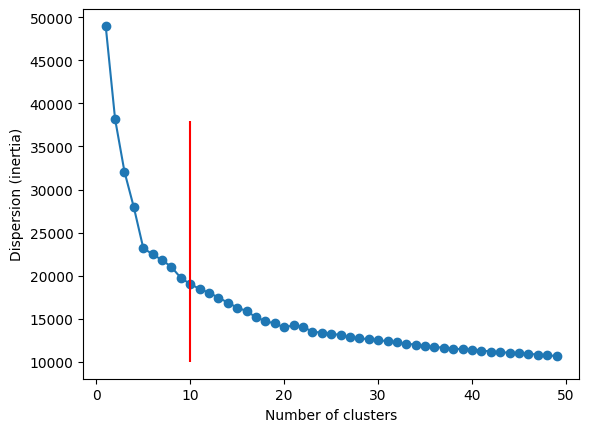

In [33]:
plt.plot(range(1, 50), dispersion, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.vlines(10, 10000, 38000, color='red')
plt.show()

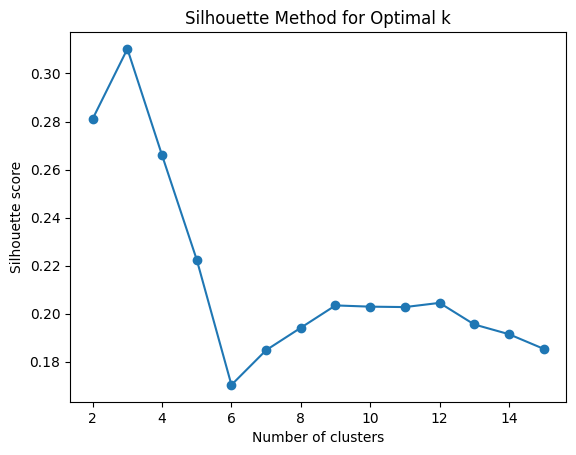

In [78]:
#Plotting the silhouette graph
plot_silhouette(cust_prepoc, max_clusters= 15)

In [34]:
# Create a K-means solution with 100 clusters to then apply the hierarchic clustering to obtain the best number of clusters
cust_copy = cust_prepoc.copy()
kmeans = KMeans(n_clusters=100, random_state=0).fit(cust_prepoc)
cust_copy['cluster_kmeans'] = kmeans.predict(cust_prepoc)

In [35]:
#From the dataset created above (that is a copy of the one after preprocessing) group by centroid 
#so we get the average per centroid to use in the agglomerative clustering

agg_knn = cust_copy.groupby("cluster_kmeans").mean()

In [36]:
# Create the hierarchical algorithm to find the best number of clusters
agg_clust = AgglomerativeClustering(linkage='ward', distance_threshold=0, n_clusters=None).fit(agg_knn)

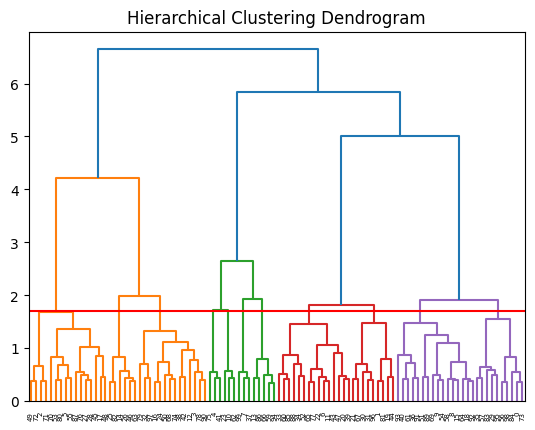

In [37]:
fig, ax = plt.subplots()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_clust, truncate_mode="level", p=50)
plt.axhline(y = 1.70, color = 'r', linestyle = '-')
plt.show()

In [38]:
kmeans_final = KMeans(n_clusters = 10, random_state=0).fit(cust_prepoc)
cust_prepoc["kmeans_cluster"] = kmeans_final.predict(cust_prepoc)

# SOM clustering

In [40]:
cust_prepoc_array = np.array(cust_prepoc.iloc[:, :-1])

In [41]:
som = MiniSom(
    5,
    5,
    cust_prepoc.iloc[:, :-1].shape[1],
    sigma=0.3,
    learning_rate=0.7,
    neighborhood_function='gaussian',
    random_seed=0
    )

In [42]:
np.random.seed(0)

num_iterations = 1000

q_errors = []
for i in range(1, num_iterations):
    som.train_batch(data = cust_prepoc_array, num_iteration= i)
    q_errors.append(som.quantization_error(cust_prepoc_array))

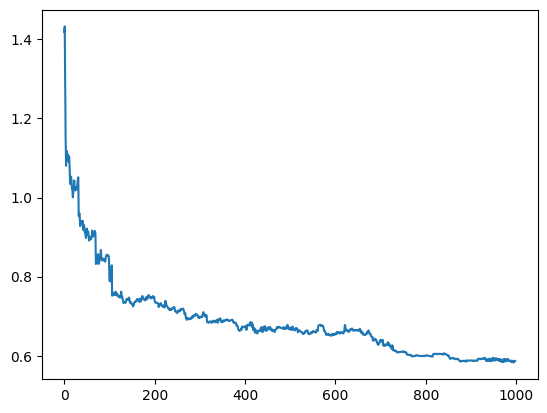

In [43]:
plt.plot(q_errors)

In [44]:
som.train(cust_prepoc_array, 400)
cust_prepoc['winner_node'] = (
    [som.winner(cust_prepoc_array[i]) for i in range(0, len(cust_prepoc_array))]
)

In [45]:
cust_prepoc["winner_node"].unique()

array([(0, 0), (4, 2), (1, 4), (1, 3), (1, 2), (4, 3), (3, 4), (3, 2),
       (2, 3), (1, 0), (2, 2), (0, 1), (2, 4), (3, 3), (0, 3), (3, 1),
       (4, 0), (2, 1), (3, 0), (0, 2), (1, 1), (0, 4), (4, 1), (2, 0),
       (4, 4)], dtype=object)

In [46]:
dict = {}
i = 0
lt = []
for ele in cust_prepoc["winner_node"]:
    if ele in dict:
        lt.append(dict[ele]) 
    else:
        dict[ele] = i
        lt.append(dict[ele])
        i += 1

In [47]:
cust_prepoc["winner_node"] = pd.Series(lt)

In [48]:
cust_prepoc

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,...,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,Age,loyalty_card,customer_gender_male,kmeans_cluster,winner_node
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,0.111111,0.166667,0.111111,0.142857,0.689440,0.334038,0.611111,0.229167,0.271583,0.185229,...,0.009029,0.328503,0.500000,0.397470,0.478999,0.596774,0.0,1.0,4,23.0
43460,0.111111,0.000000,0.111111,0.142857,0.188875,0.062709,0.111111,0.162879,0.168165,0.239049,...,0.724041,0.408523,0.642857,0.636523,0.413765,0.225806,0.0,0.0,2,NaN
23937,0.000000,0.166667,0.111111,0.285714,0.116639,0.191463,0.222222,0.142519,0.383094,0.340012,...,0.361738,0.366693,0.464286,0.236664,0.389840,0.532258,1.0,0.0,0,11.0
2431,0.000000,0.000000,0.000000,0.000000,0.407691,0.009731,0.611111,0.072443,0.113309,0.011786,...,0.019752,0.414270,0.392857,0.808462,0.472062,0.967742,1.0,0.0,0,21.0
10090,0.000000,0.000000,0.000000,0.000000,0.026250,0.026795,0.611111,0.003788,0.014838,0.556472,...,0.001129,0.393475,1.000000,0.704482,0.323561,0.000000,1.0,1.0,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48487,0.111111,0.166667,0.000000,0.000000,0.270752,0.295821,0.611111,0.321023,0.333183,0.125516,...,0.003950,0.424663,0.714286,0.618787,0.384052,0.290323,0.0,0.0,8,NaN
24856,0.111111,0.166667,0.111111,0.000000,0.423245,0.540121,0.333333,0.285038,0.250450,0.295227,...,0.007054,0.321799,0.642857,0.615128,0.381284,0.145161,1.0,0.0,8,4.0
21373,0.000000,0.000000,0.000000,0.000000,0.228194,0.011329,0.333333,0.136837,0.188849,0.008446,...,0.012415,0.343708,0.750000,0.700302,0.298395,0.129032,0.0,0.0,2,0.0


## DBScan

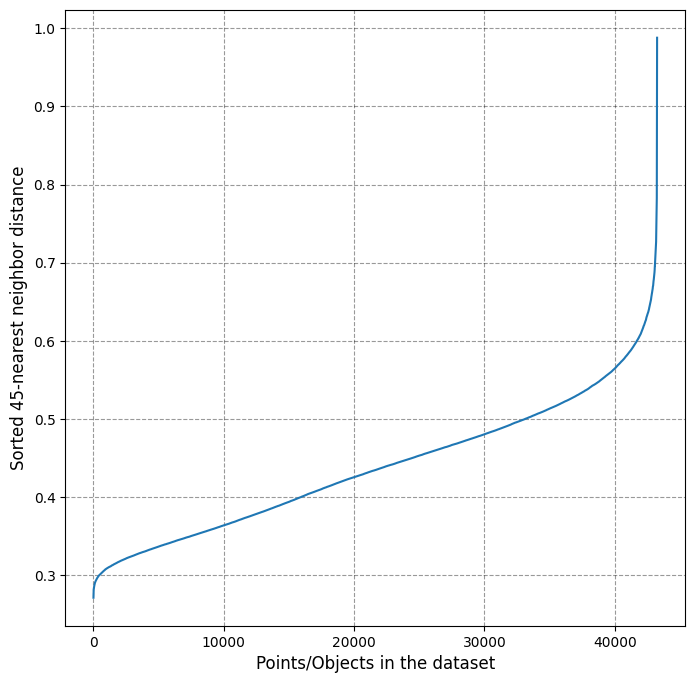

In [49]:
k = 2 * cust_prepoc.iloc[:, :-2].shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=cust_prepoc.iloc[:, :-2], k=k)

In [50]:
cust_prepoc['dbscan_clustering'] = DBSCAN(
    eps=0.68, min_samples=k
    ).fit_predict(cust_prepoc.iloc[:, :-2])

In [51]:
cust_prepoc['dbscan_clustering'].value_counts()

dbscan_clustering
 2    12176
 3    12168
 1     9541
 0     9354
-1        4
Name: count, dtype: int64

## UMAP

In [52]:
umap_object = umap.UMAP(n_neighbors=100, min_dist=0.7, random_state=0)

In [53]:
cust_prepoc = cust_prepoc.sort_index()

In [54]:
umap_embedding = umap_object.fit_transform(cust_prepoc.iloc[:, :-3])

C:\Users\joaof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


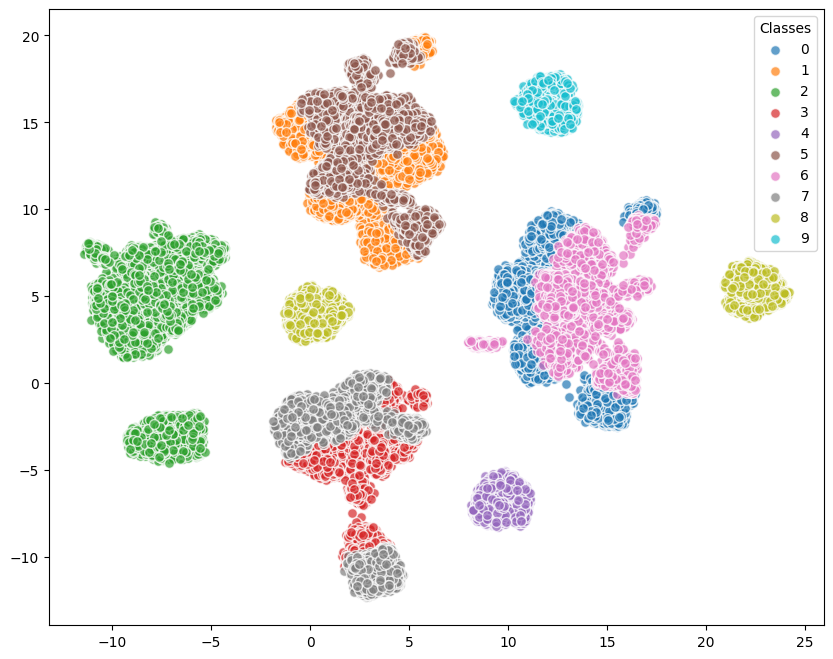

In [55]:
visualize_dimensionality_reduction_umap(umap_embedding, cust_prepoc.iloc[:,-3].sort_index())

In [56]:
umap_object_2 = umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=0)

In [57]:
umap_embedding_2 = umap_object_2.fit_transform(cust_prepoc.iloc[:, :-3])

C:\Users\joaof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


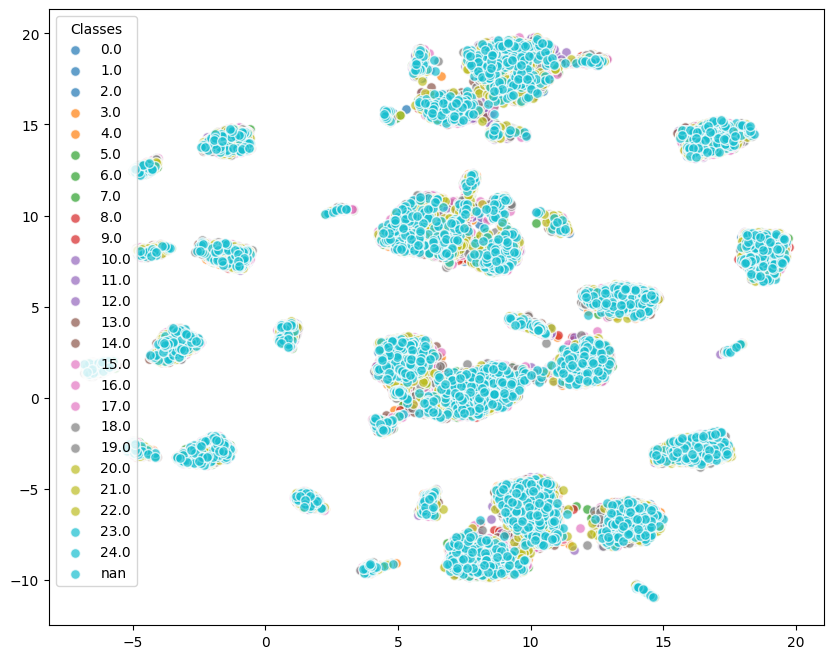

In [58]:
visualize_dimensionality_reduction_umap(umap_embedding_2, cust_prepoc.iloc[:,-2].sort_index())

In [59]:
umap_object_3 = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=0)

In [60]:
umap_embedding_3 = umap_object_3.fit_transform(cust_prepoc.iloc[:, :-3])

C:\Users\joaof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


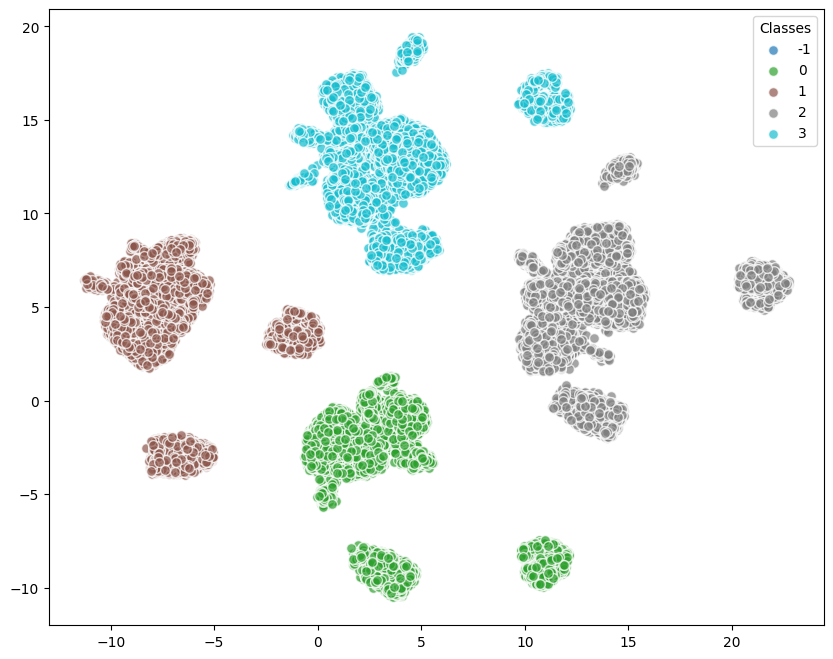

In [62]:
visualize_dimensionality_reduction_umap(umap_embedding_3, cust_prepoc.iloc[:,-1].sort_index())